In [1]:
from mcmc import initialize_slab, spin_flip, mcmc_run, get_random_idx
from catkit.gen.adsorption import get_adsorption_sites

from ase.calculators.eam import EAM
from ase.calculators.lammpsrun import LAMMPS

import os
import numpy as np

In [2]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab
state = np.zeros(len(coords), dtype=int)

temp = 300
pot = 2

In pristine slab, there are a total of 32 sites


In [ ]:
# test top
top_site = get_random_idx(connectivity, type="top")
bridge_site = get_random_idx(connectivity, type="bridge")
hollow_site = get_random_idx(connectivity, type="hollow")

# add to 3 sites
spin_flip(state, slab, temp, pot, coords, connectivity, save_cif=True, iter=1, site_idx=top_site, testing=True, folder_name="different_sites_noalat")
spin_flip(state, slab, temp, pot, coords, connectivity, save_cif=True, iter=2, site_idx=bridge_site, testing=True, folder_name="different_sites_noalat")
spin_flip(state, slab, temp, pot, coords, connectivity, save_cif=True, iter=3, site_idx=hollow_site, testing=True, folder_name="different_sites_noalat")

In [ ]:
# perform 5 test iterations
site1 = len(state)-1
site2 = len(state)-2
site3 = len(state)-3

# add to 3 sites
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, save_cif=True, iter=1, site_idx=site1, testing=True, folder_name="different_sites_noalat")
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, prev_energy=energy, save_cif=True, iter=2, site_idx=site2, testing=True, folder_name="different_sites_noalat")
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, prev_energy=energy, save_cif=True, iter=3, site_idx=site3, testing=True, folder_name="different_sites_noalat")

# remove from 2nd site
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, prev_energy=energy, save_cif=True, iter=4, site_idx=site2, testing=True, folder_name="different_sites_noalat")
# remove from 1st site
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, prev_energy=energy, save_cif=True, iter=5, site_idx=site1, testing=True, folder_name="different_sites_noalat")

# add to 1st site again
state, slab, energy, _ = spin_flip(state, slab, temp, pot, coords, connectivity, prev_energy=energy, save_cif=True, iter=6, site_idx=site1, testing=True, folder_name="different_sites_noalat")

In [3]:
from time import perf_counter

start = perf_counter()
# chem pot 0 to less complicate things
# temp in terms of kbT
# no cooling
# 20 runs
num_runs = 40

# use EAM
eam_calc = EAM(potential='Cu2.eam.fs')

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=0.99, slab=None, calc=lammps_calc)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

INFO:Running with num_runs = 40, temp = 1, pot = 0, alpha = 0.99
INFO:initializing slab
INFO:In pristine slab, there are a total of 32 sites


there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e20344a90>


INFO:running for 32 iterations per run over a total of 40 runs
INFO:In sweep 1 out of 40
INFO:In sweep 2 out of 40
INFO:In sweep 3 out of 40
INFO:In sweep 4 out of 40
INFO:In sweep 5 out of 40
INFO:In sweep 6 out of 40
INFO:In sweep 7 out of 40
INFO:In sweep 8 out of 40
INFO:In sweep 9 out of 40
INFO:In sweep 10 out of 40
INFO:In sweep 11 out of 40
INFO:In sweep 12 out of 40
INFO:In sweep 13 out of 40
INFO:In sweep 14 out of 40
INFO:In sweep 15 out of 40
INFO:In sweep 16 out of 40
INFO:In sweep 17 out of 40
INFO:In sweep 18 out of 40
INFO:In sweep 19 out of 40
INFO:In sweep 20 out of 40
INFO:In sweep 21 out of 40
INFO:In sweep 22 out of 40
INFO:In sweep 23 out of 40
INFO:In sweep 24 out of 40
INFO:In sweep 25 out of 40
INFO:In sweep 26 out of 40
INFO:In sweep 27 out of 40
INFO:In sweep 28 out of 40
INFO:In sweep 29 out of 40
INFO:In sweep 30 out of 40
INFO:In sweep 31 out of 40
INFO:In sweep 32 out of 40
INFO:In sweep 33 out of 40
INFO:In sweep 34 out of 40
INFO:In sweep 35 out of 40
I

Time taken = 15.92935811728239 seconds


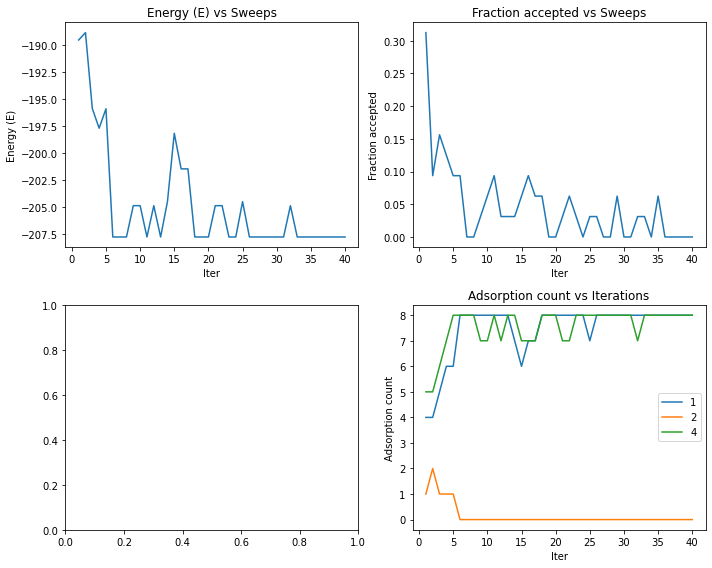

In [4]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Coarse grain work

In [6]:
from time import perf_counter

chem_pots = np.linspace(-4.0, 4.0, 9)
# chem_pots = [0] # do just one
num_runs = 100
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc=lammps_calc)
    
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

INFO:Running with num_runs = 100, temp = 1, pot = -4.0, alpha = 0.99
INFO:initializing slab
INFO:In pristine slab, there are a total of 32 sites


there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 36.4159891307354 seconds


INFO:In pristine slab, there are a total of 32 sites


there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 37.2983149215579 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 37.340165719389915 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 38.19883123040199 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 38.21946006268263 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 36.90679816156626 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 100
INFO:In sweep 33 out of 100
INFO:In sweep 34 out 

Time taken = 37.468730233609676 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:In pristine slab, there are a total of 32 sites
INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 

Time taken = 36.595758736133575 seconds
there are 48 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f9e1d10b910>


INFO:In pristine slab, there are a total of 32 sites
INFO:running for 32 iterations per run over a total of 100 runs
INFO:In sweep 1 out of 100
INFO:In sweep 2 out of 100
INFO:In sweep 3 out of 100
INFO:In sweep 4 out of 100
INFO:In sweep 5 out of 100
INFO:In sweep 6 out of 100
INFO:In sweep 7 out of 100
INFO:In sweep 8 out of 100
INFO:In sweep 9 out of 100
INFO:In sweep 10 out of 100
INFO:In sweep 11 out of 100
INFO:In sweep 12 out of 100
INFO:In sweep 13 out of 100
INFO:In sweep 14 out of 100
INFO:In sweep 15 out of 100
INFO:In sweep 16 out of 100
INFO:In sweep 17 out of 100
INFO:In sweep 18 out of 100
INFO:In sweep 19 out of 100
INFO:In sweep 20 out of 100
INFO:In sweep 21 out of 100
INFO:In sweep 22 out of 100
INFO:In sweep 23 out of 100
INFO:In sweep 24 out of 100
INFO:In sweep 25 out of 100
INFO:In sweep 26 out of 100
INFO:In sweep 27 out of 100
INFO:In sweep 28 out of 100
INFO:In sweep 29 out of 100
INFO:In sweep 30 out of 100
INFO:In sweep 31 out of 100
INFO:In sweep 32 out of 

Time taken = 37.93350798636675 seconds


In [ ]:
import matplotlib.pyplot as plt
# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()

Fine grain work

In [ ]:
from time import perf_counter

chem_pots = np.linspace(-3.125, -2.75, 5)
# chem_pots = [0] # do just one
num_runs = 500
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc=lammps_calc)
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()